# Prototipo simulador parte 1: Modelo de la mecánica pulmonar

In [1]:
# Librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Estilo
plt.style.use('seaborn-v0_8-whitegrid')

En cumplimiento del primer objetivo, se establecieron cuáles eran los modelos que se iban a implementar en este módulo. Este primer prototipo será el MVP, un prototipo funcional que sólo implementa el módulo mecánico, sobre el cual se iterará para implementar los siguientes modelos. 

## El modelo a implementar

Como se detalla en el documento del trabajo de grado, durante el desarrollo del objetivo 1 se definió implementar como módulo mecánico el modelo de dos compartimientos en paralelo. Las ecuaciones que lo describen son:

$ P_{aw} (t) = E_1 V_1(t) + R_1 \dot{V}_1 (t) = E_2 V_2(t) + R_2 \dot{V}_2 (t)$  
$ V_{total} = V_1(t) + V_2(t)$  
$ \dot{V}_{total} (t) = \dot{V}_1 + \dot{V}_2 $

Así que se traduce este sistema de ecuaciones diferenciales a una función, que será el componente más importante del prototipo:

In [2]:
def modelo_dos_compartimentos(t, y, P_aw_func, R1, E1, R2, E2):
    """
    Define el sistema de EDOs para el modelo de dos compartimentos.
    
    Argumentos:
    t: tiempo actual
    y: arreglo con los valores actuales de las variables de estado [V1, V2].
    P_aw_func: una función que devuelve la presión aplicada (Paw) en el tiempo t.
    R1, E1, R2, E2: parámetros de resistencia y elastancia de los compartimentos.
    
    Retorna:
    Una lista con las derivadas de cada variable de estado: [dV1/dt, dV2/dt].
    """
    V1, V2 = y
    P_aw = P_aw_func(t)
    
    # Ecuaciones diferenciales del modelo, reorganizadas para dV/dt
    # dV1/dt = (P_aw - E1 * V1) / R1
    # dV2/dt = (P_aw - E2 * V2) / R2
    
    dV1_dt = (P_aw - E1 * V1) / R1
    dV2_dt = (P_aw - E2 * V2) / R2
    
    return [dV1_dt, dV2_dt]

Para este MVP, se va a simular una ventilación controlada por presión (PCV), porque es la más simple de modelar (onda de presión cuadrada). Se configuran unos parámetros genéricos de un paciente simulado:

In [6]:
# --- PARÁMETROS DEL PACIENTE SIMULADO ---
R1 = 5      # Resistencia del compartimento 1 (cmH2O/L/s)
C1 = 0.05   # Compliancia del compartimento 1 (L/cmH2O)
E1 = 1 / C1 # Elastancia del compartimento 1

R2 = 10     # Resistencia del compartimento 2 (más alta)
C2 = 0.03   # Compliancia del compartimento 2 (más baja)
E2 = 1 / C2 # Elastancia del compartimento 2

# --- PARÁMETROS DEL VENTILADOR (MODO PCV) ---
PEEP = 5.0          # Presión Positiva al Final de la Espiración (cmH2O)
P_driving = 15.0      # Presión de conducción por encima de PEEP (cmH2O)
P_control = PEEP + P_driving # Presión control total
T_insp = 1.0        # Tiempo inspiratorio (s)
T_total = 3.0       # Duración total del ciclo respiratorio (frecuencia = 20/min)

# --- FUNCIÓN DE ENTRADA (PRESIÓN) ---
# Define la onda cuadrada de presión para el modo PCV
def presion_pcv(t):
    """
    Calcula la presión aplicada para un tiempo o arreglo de tiempos t.
    """
    # np.where(condición, valor_si_verdadero, valor_si_falso)
    return np.where(t < T_insp, P_control, PEEP)

Teniendo ya definidos el modelo y unos parámetros simulados para el primer prototipo, se resuelven las ecuaciones con ´solve_ivp´de SciPy:

In [7]:
# Condiciones iniciales: El ciclo empieza con los pulmones en PEEP, sin volumen adicional.
V_inicial = [0, 0]

# Tiempo a simular
t_span = [0, T_total]
# Puntos de tiempo donde queremos la solución (para graficar)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solución del sistema de EDOs.
solucion = solve_ivp(
    fun=modelo_dos_compartimentos,
    t_span=t_span,
    y0=V_inicial,
    t_eval=t_eval,
    args=(presion_pcv, R1, E1, R2, E2),
    dense_output=True # Nos permite calcular la solución en cualquier punto
)

Se toman los datos de la solución y se grafican para verlos/entenderlos:

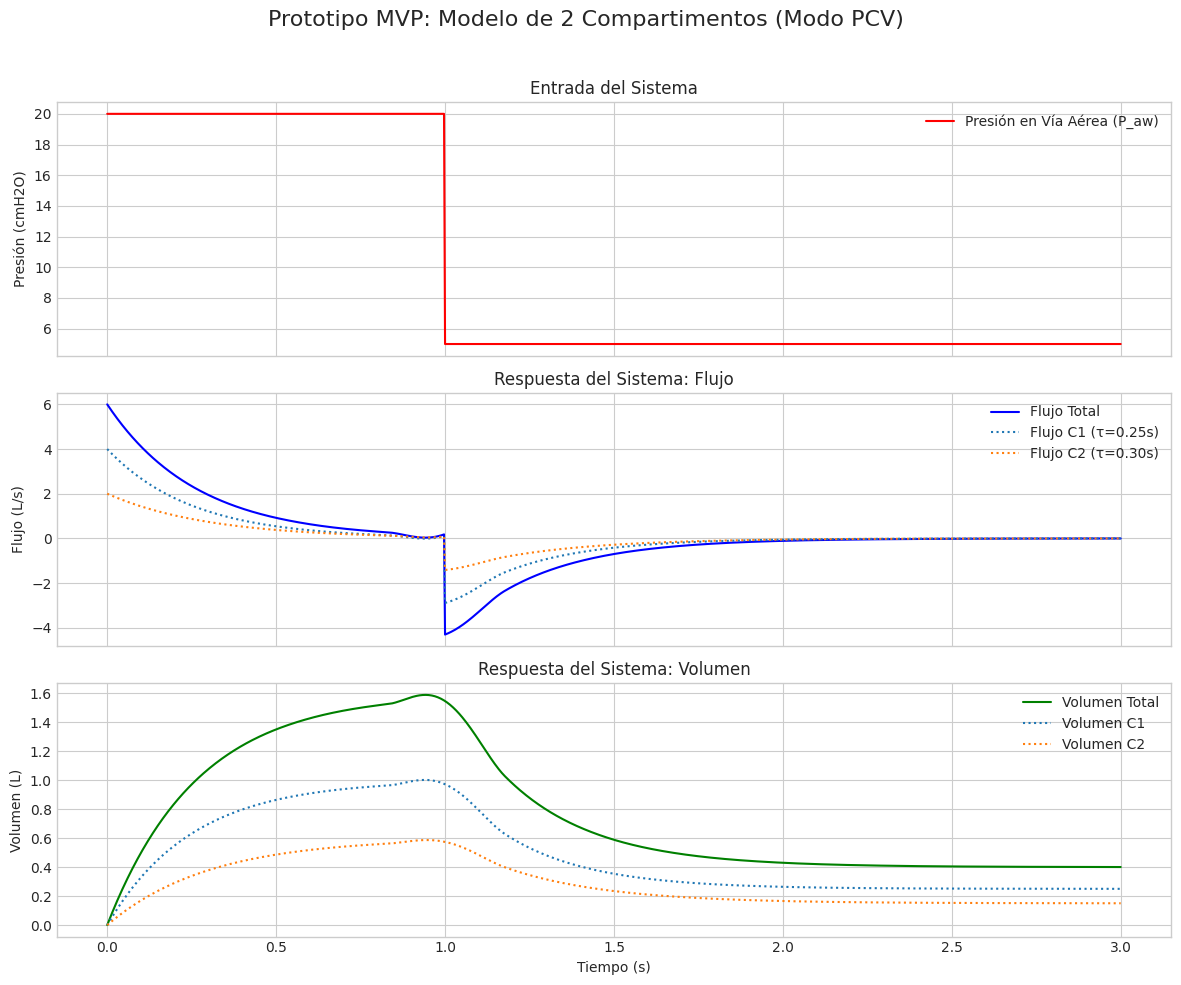

In [9]:
# --- PROCESAMIENTO DE RESULTADOS ---
# Extraer volúmenes de la solución
V1 = solucion.y[0]
V2 = solucion.y[1]
V_total = V1 + V2

# Calcular flujos usando la función del modelo.
# Ahora podemos pasar t_eval directamente porque presion_pcv es vectorizada.
flujo1, flujo2 = modelo_dos_compartimentos(t_eval, solucion.y, presion_pcv, R1, E1, R2, E2)
flujo_total = np.array(flujo1) + np.array(flujo2)

# Obtener la curva de presión es ahora más simple y eficiente
P_aplicada = presion_pcv(t_eval)

# --- VISUALIZACIÓN ---
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Prototipo MVP: Modelo de 2 Compartimentos (Modo PCV)', fontsize=16)

# 1. Gráfica de Presión
axs[0].plot(t_eval, P_aplicada, label='Presión en Vía Aérea (P_aw)', color='red')
axs[0].set_ylabel('Presión (cmH2O)')
axs[0].legend()
axs[0].set_title('Entrada del Sistema')

# 2. Gráfica de Flujo
axs[1].plot(t_eval, flujo_total, label='Flujo Total', color='blue')
axs[1].plot(t_eval, flujo1, label=f'Flujo C1 (τ={R1*C1:.2f}s)', linestyle=':')
axs[1].plot(t_eval, flujo2, label=f'Flujo C2 (τ={R2*C2:.2f}s)', linestyle=':')
axs[1].set_ylabel('Flujo (L/s)')
axs[1].legend()
axs[1].set_title('Respuesta del Sistema: Flujo')

# 3. Gráfica de Volumen
axs[2].plot(t_eval, V_total, label='Volumen Total', color='green')
axs[2].plot(t_eval, V1, label='Volumen C1', linestyle=':')
axs[2].plot(t_eval, V2, label='Volumen C2', linestyle=':')
axs[2].set_ylabel('Volumen (L)')
axs[2].set_xlabel('Tiempo (s)')
axs[2].legend()
axs[2].set_title('Respuesta del Sistema: Volumen')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()